**CNN with Custom Images (Crosses and Circles)**

In [32]:
! pip install split-folders

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [35]:
#Define the transforms
transform = transforms.Compose([transforms.ToTensor()])

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Prepare the train and test sets, loaders
#Basically the train-test split
splitfolders.ratio("Circle_Cross", output="output", seed=1478, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 2001 files [27:41,  1.20 files/s]


In [39]:
train_data = datasets.ImageFolder('output/train', transform = transform)
test_data = datasets.ImageFolder('output/val', transform = transform)

In [40]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['circles', 'crosses']
Training images available: 1599
Testing images available:  401


In [41]:
# Display a batch of the images
for images,labels in train_loader:
    break
images.shape

torch.Size([32, 3, 116, 116])

In [42]:
labels

tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1])

Label: [1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1]
Class: crosses crosses circles circles circles circles circles crosses circles circles circles crosses circles circles crosses circles crosses circles crosses crosses circles circles crosses crosses crosses circles crosses crosses crosses crosses circles crosses


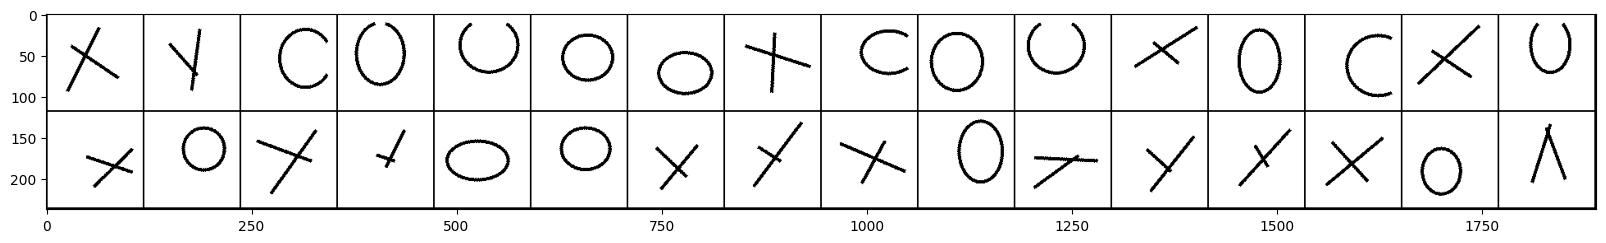

In [43]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=16)  # 16 images in a row. the default nrow is 8

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # we see that dataloader has shuffle the images

In [44]:
#Creating the CNN

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining Convolutional Layers

        self.conv1 = nn.Conv2d(3, 10, 5, 1, 1)
        # 3 = channel, 10 = number of kernels, 5 = kernel_size, 1 = Stride, 1 = padding
        self.conv2 = nn.Conv2d(10, 20, 5, 1, 1)

        # Definig Fully connected Layers

        self.fc = nn.LazyLinear(64)
        self.output = nn.Linear(64,2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = torch.flatten(X, 1) # Will be used with LazyLinear
        X = self.fc(X)
        X = F.relu(X)
        X = self.output(X)
        return X

In [50]:
model = CNN()

# count the total number of parameters in the model
summary(model.cuda(),(3,116,116))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 114, 114]             760
            Conv2d-2           [-1, 20, 55, 55]           5,020
            Linear-3                   [-1, 64]         933,184
            Linear-4                    [-1, 2]             130
Total params: 939,094
Trainable params: 939,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 1.45
Params size (MB): 3.58
Estimated Total Size (MB): 5.19
----------------------------------------------------------------


In [51]:
epochs = 25

# loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01)

model.to(device) # placing a model on GPU

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 model.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
  if (epoch % 5) == 0:

        print(f' epochs : {epoch}  loss : {loss}')



 epochs : 0  loss : 0.5093698501586914
 epochs : 5  loss : 0.09145926684141159
 epochs : 10  loss : 0.0010435404255986214
 epochs : 15  loss : 1.9927991161239333e-05
 epochs : 20  loss : 0.00013264294830150902


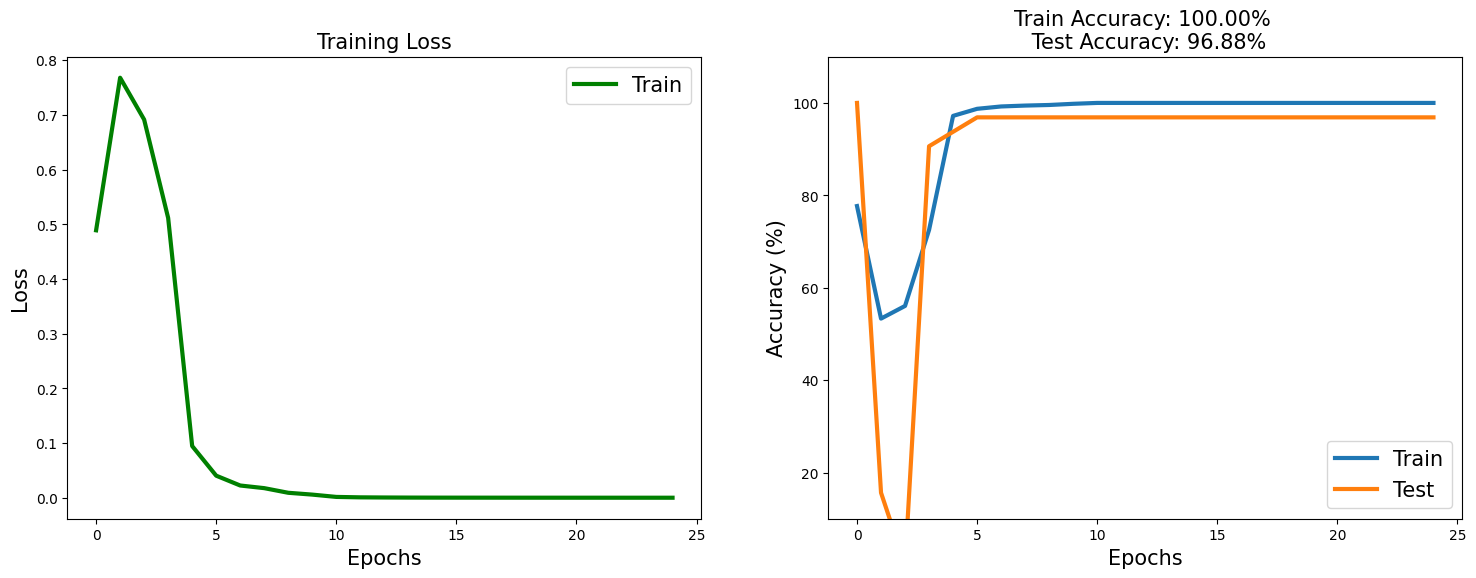

In [52]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()